# Обработка данных

In [113]:
%env RESULT_PATH=/Users/mplobanov/Downloads/diploma/results

env: RESULT_PATH=/Users/mplobanov/Downloads/diploma/results


In [114]:
from os import listdir, environ
from os.path import isfile, join
PATH = environ['RESULT_PATH']
onlyfiles = [f for f in listdir(PATH) if isfile(join(PATH, f))]

In [115]:
import json
data_pieces = []
for path in onlyfiles:
    with open(f"{PATH}/{path}", 'r') as fin:
        data = json.load(fin)
        for key in ['N', 'M', 'K', 'type', 'trials']:
            data[key] = [data[key] for _ in range(data['trials'])]
        data_pieces.append(data)

In [116]:
import pandas as pd

In [117]:
data = pd.concat([pd.DataFrame(piece) for piece in data_pieces])

In [118]:
data = data.reset_index().drop(columns='index')

In [119]:
data['volume'] = data['N'] * data['M'] * data['K']

In [120]:
data.to_csv('data/data1.csv')

In [68]:
data.loc[0, 'times']

91.60000002384186

In [64]:
import statsmodels.api as sm
import numpy as np

In [71]:
from scipy.stats import shapiro 

Проверим выборки на нормальность:

In [80]:
data.pivot_table(values='times', index='volume', columns='type', aggfunc=lambda x: shapiro(x).pvalue)

type,plain-js,tf-cpu,tf-wasm,tf-webgl,tf-webgpu
volume,,,,,
1000000,1.369649e-17,9.034100e-21,1.307299e-19,5.321905e-17,1.441621e-15
125000000,9.909291e-08,2.295846e-11,1.359756e-03,2.056285e-12,2.884816e-11
1000000000,1.356206e-04,2.119820e-05,1.382715e-01,2.567359e-07,2.030867e-06
8000000000,NaN,2.867850e-02,9.926027e-01,2.819268e-02,3.280273e-02


In [121]:
data.pivot_table(values='times', index='volume', columns='type', aggfunc='count')

type,plain-js,tf-cpu,tf-wasm,tf-webgl,tf-webgpu
volume,,,,,
1000000,100.0,100.0,100.0,100.0,100.0
125000000,70.0,70.0,70.0,70.0,70.0
1000000000,20.0,20.0,20.0,20.0,20.0
8000000000,NaN,5.0,5.0,5.0,5.0


Выборки явно не из нормального распределения. Посмотрим среднее:

In [93]:
data['volume_log'] = np.log(data['volume'])

In [90]:
mean_table = data.pivot_table(values='times', index='volume', columns='type')
mean_table

type,plain-js,tf-cpu,tf-wasm,tf-webgl,tf-webgpu
volume,,,,,
1000000,6.687000,3.734000,0.847000,11.034000,6.049000
125000000,1316.085714,376.207143,34.672857,43.797143,30.061429
1000000000,16523.885000,2948.185000,194.170000,146.250000,127.485000
8000000000,NaN,24689.080000,1195.780000,720.320000,509.060000


<Axes: xlabel='volume_log'>

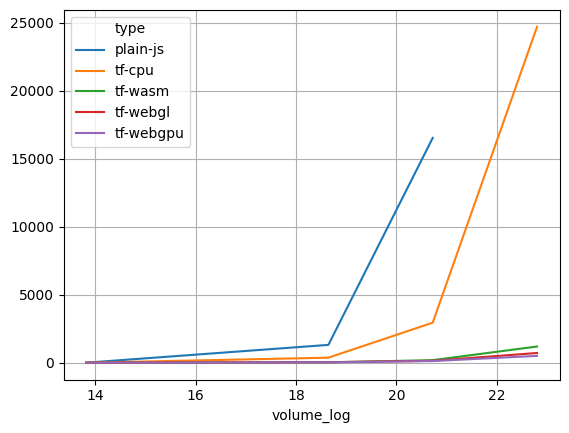

In [97]:
data.pivot_table(values='times', index='volume_log', columns='type').plot(grid=True)

Понятно, что можно разделить подходы на две группы: **основаннные на cpu** и **использующие ускоряющие технологии**. CPU безнадежно отстает в производительности. WebAssembly, WebGPU и WebGL требуют дальнейшего исследования. Посмотрим в логарифмическом масштабе.

<Axes: xlabel='volume_log'>

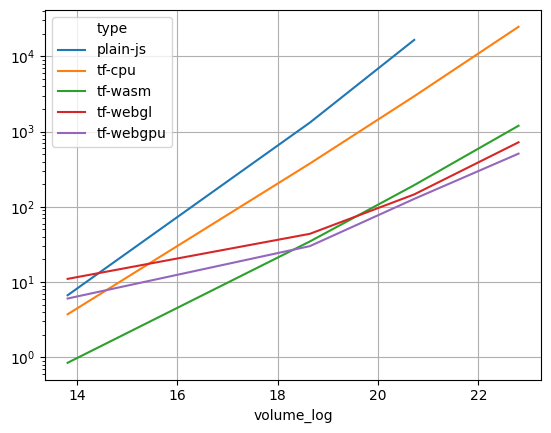

In [98]:
data.pivot_table(values='times', index='volume_log', columns='type').plot(grid=True, logy=True)

Видим, что на малых объемах данных WebGPU и WebGL имеют более низкую относительную производительность. Это связано с оверхедом использования графической карты (перенос данных туда/обратно)

Пристальнее посмотрим на ускоренные подходы:

In [122]:
%env RESULT_PATH=/Users/mplobanov/Downloads/diploma/results/more

env: RESULT_PATH=/Users/mplobanov/Downloads/diploma/results/more


In [123]:
PATH = environ['RESULT_PATH']
onlyfiles = [f for f in listdir(PATH) if isfile(join(PATH, f))]

In [124]:
data_pieces = []
for path in onlyfiles:
    with open(f"{PATH}/{path}", 'r') as fin:
        data = json.load(fin)
        for key in ['N', 'M', 'K', 'type', 'trials']:
            data[key] = [data[key] for _ in range(data['trials'])]
        data_pieces.append(data)

In [125]:
data = pd.concat([pd.DataFrame(piece) for piece in data_pieces])

In [126]:
data = data.reset_index().drop(columns='index')

In [127]:
data['volume'] = data['N'] * data['M'] * data['K']

In [107]:
data.to_csv('data/data2.csv')

In [131]:
data.loc[0, 'times']

405.5999999642372

In [132]:
data['volume_log'] = np.log(data['volume'])

In [133]:
mean_table = data.pivot_table(values='times', index='volume', columns='type')
mean_table

type,tf-wasm,tf-webgl,tf-webgpu
volume,,,
343000000,75.734,83.230,62.560
1000000000,189.450,137.394,119.898
2197000000,364.190,223.086,193.644
4096000000,641.606,341.194,305.602
8000000000,1146.542,694.236,481.706
12167000000,1768.962,763.502,678.838


In [135]:
data.pivot_table(values='times', index='volume', columns='type', aggfunc='count')

type,tf-wasm,tf-webgl,tf-webgpu
volume,,,
343000000,50,50,50
1000000000,50,50,50
2197000000,50,50,50
4096000000,50,50,50
8000000000,50,50,50
12167000000,50,50,50


<Axes: xlabel='volume'>

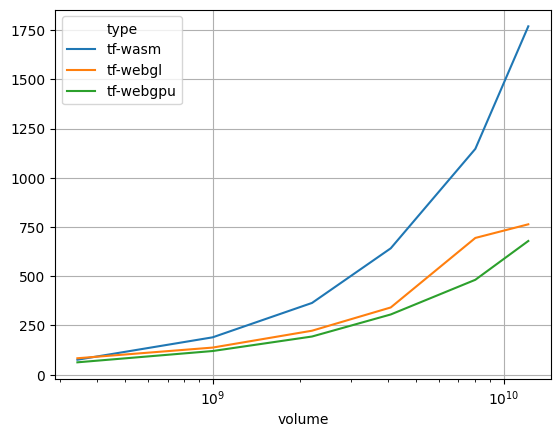

In [111]:
data.pivot_table(values='times', index='volume', columns='type').plot(grid=True, logx=True)

<Axes: xlabel='volume'>

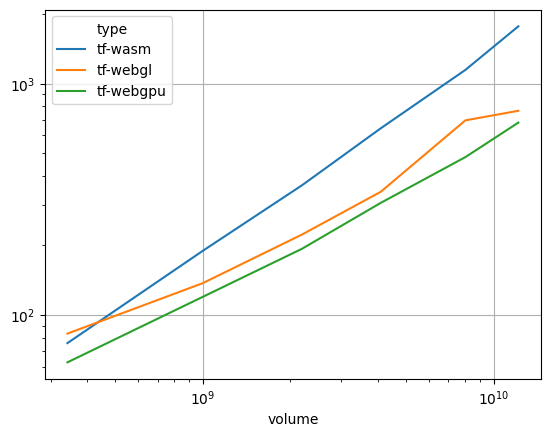

In [112]:
data.pivot_table(values='times', index='volume', columns='type').plot(grid=True, loglog=True)

Можем сделать вывод, что WebGL и WebGPU имеют некоторый оверхед, но эффективнее на больших данных. WebAssembly показывает низкий оверхед, но и менее производителен.

In [136]:
from scipy.stats import mannwhitneyu

In [141]:
get_sample = lambda engine, size: data[np.logical_and(data['type'] == engine, data['N'] == size)]['times']

In [154]:
for size in np.sort(data['N'].unique()):
    print(f"Size = {size}, {mannwhitneyu(get_sample('tf-webgpu', size), get_sample('tf-webgl', size)).pvalue}")

Size = 700, 5.978914224436698e-13
Size = 1000, 1.8957598454209575e-13
Size = 1300, 3.3778956718904325e-16
Size = 1600, 1.4269311057245712e-16
Size = 2000, 7.062885236832336e-18
Size = 2300, 6.685229827250931e-16


In [155]:
from scipy.stats import ranksums

In [156]:
for size in np.sort(data['N'].unique()):
    print(f"Size = {size}, {ranksums(get_sample('tf-webgpu', size), get_sample('tf-webgl', size)).pvalue}")

Size = 700, 5.845344687756845e-13
Size = 1000, 1.8508119437323456e-13
Size = 1300, 3.287515693468304e-16
Size = 1600, 1.388890058422927e-16
Size = 2000, 6.856641447475644e-18
Size = 2300, 6.500252974712035e-16
